# Orthogonal Polynomial regression

This example has been contributed by Tyler James Burch ([\@tjburch](https://github.com/tjburch) on GitHub). While the content in this notebook can stand alone, it is a companion to the [polynomial regression notebook](https://bambinos.github.io/bambi/notebooks/polynomial_regression.html), which contains additional useful examples. 

In [1]:
import arviz as az
import bambi as bmb
import formulae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from typing import Optional

plt.style.use("arviz-darkgrid")
SEED = 1234
np.random.seed(SEED)

In [2]:
# Temporary fix to make outputs cleaner
import warnings
warnings.filterwarnings("ignore")

## Revisiting Polynomial Regression

To start, we'll recreate the projectile motion data defined in the [polynomial regression notebook](https://bambinos.github.io/bambi/notebooks/polynomial_regression.html) with $x_0 = 1.5$ $m$ and $v_0 = 7$ $m$/$s$. This will follow:

$$
x_f = \frac{1}{2} g t^2 + v_0 t + x_0
$$

Where $g$ will be the acceleration of gravity on Earth, $-9.81$ $m$/$s^2$. First we'll generate the data.

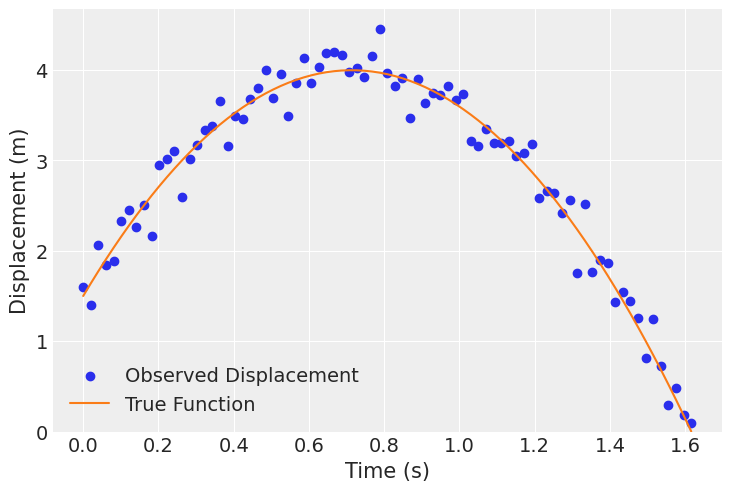

In [3]:
g = -9.81
v0 = 7
x0 = 1.5
t = np.linspace(0, 2, 100)
x_projectile = (1/2) * g * t**2 + v0 * t + x0
noise = np.random.normal(0, 0.2, x_projectile.shape)
x_obs_projectile = x_projectile + noise
df_projectile = pd.DataFrame({"t": t, "x": x_obs_projectile, "x_true": x_projectile})
df_projectile = df_projectile[df_projectile["x"] >= 0]

plt.scatter(df_projectile.t, df_projectile.x, label='Observed Displacement', color="C0")
plt.plot(df_projectile.t, df_projectile.x_true, label='True Function', color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.ylim(bottom=0)
plt.legend()
plt.show()

Putting this into Bambi, we set $\beta_2 = \frac{g}{2}$, $\beta_1 = v_0$, and $\beta_0 = x_0$, then perform the following regression:

$$
x_f = \beta_2 t^2 + \beta_1 t + \beta_0
$$

We expect to recover $\beta_2 = -4.905$, $\beta_1 = 7$, $\beta_0 = 1.5$ from our fit. We start with the approach from the other notebook where we explicitly tell formulae to calculate coefficients on $t^2$ and $t$.

In [4]:
model_projectile_all_terms = bmb.Model("x ~ I(t**2) + t + 1", df_projectile)
fit_projectile_all_terms = model_projectile_all_terms.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)
az.summary(fit_projectile_all_terms)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, I(t ** 2), t]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I(t ** 2),-4.875,0.112,-5.095,-4.673,0.002,0.002,2121.0,2049.0,1.0
Intercept,1.518,0.066,1.389,1.636,0.001,0.001,2299.0,2047.0,1.0
sigma,0.201,0.016,0.172,0.232,0.000,0.000,2950.0,2330.0,1.0
t,6.962,0.187,6.622,7.325,0.004,0.003,1958.0,1925.0,1.0


The parameters are recovered as anticipated.

If you want to include _all_ terms of a variable up to a given degree, you can also use the keyword `poly`. So if we want the linear and quadratic effects, as in this case, we would designate `poly(t, 2)`.

In [5]:
model_projectile_poly = bmb.Model("x ~ poly(t, 2) + 1", df_projectile)
fit_projectile_poly = model_projectile_poly.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(t, 2)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [6]:
az.summary(fit_projectile_poly)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.872,0.023,2.828,2.913,0.000,0.000,5984.0,3512.0,1.0
"poly(t, 2)[0]",-3.893,0.204,-4.275,-3.504,0.003,0.002,6053.0,3345.0,1.0
"poly(t, 2)[1]",-8.770,0.196,-9.141,-8.413,0.003,0.002,4844.0,3327.0,1.0
sigma,0.201,0.016,0.171,0.232,0.000,0.000,7190.0,3089.0,1.0


Now there are fitted coefficients for $t$ and $t^2$, but wait, those aren't the parameters we used! What's going on here?

## The `poly` Keyword

To fully understand what's going on under the hood, we must wade into some linear algebra. When the `poly` keyword is used, instead of directly using the values of $x, x^2, x^3, \dots, x^n$, it converts them into _orthogonal polynomials_. When including the effect from multiple polynomial terms, there will generally be correlation between them. Including all of these into a model can be a problem from the fitting perspective due to multicollinearity. By orthogonalizing, the correlation is removed by design. 

As it turns out, it's difficult to get any information on _how_ the orthogonalization is performed. [Here is the implementation for `poly` in formulae](https://github.com/bambinos/formulae/blob/b00f53da4b092ea13eeeabe92866736e97d56db0/formulae/transforms.py#L400-L426), but to fully understand, I went into the [source code for the R Stats library](https://svn.r-project.org/R/trunk/src/library/stats/R/contr.poly.R) where `poly` is defined as a function for use on any vector, and took a look at its code. 

Here's a step-by-step summary, along with a toy example for $x^4$.

- The data is first centered around the mean for stability

In [7]:
X = np.array([1, 2, 3, 4, 5])

mean = np.mean(X)
X_centered = X - mean
print(f"Array: {X}, mean: {mean}.\nCentered: {X_centered}")

Array: [1 2 3 4 5], mean: 3.0.
Centered: [-2. -1.  0.  1.  2.]


- A _Vandermonde matrix_ is created. This just takes the input data and generates a matrix where columns represent increasing polynomial degrees. In this example, the first column is $x^0$, a constant term. The second is $x^1$, or the centered data. The third column is $x^2$, the fourth is $x^3$, the last is $x^4$.

In [8]:
degree = 4
simple_vander = np.vander(X_centered, N=degree+1, increasing=True)
simple_vander

array([[ 1., -2.,  4., -8., 16.],
       [ 1., -1.,  1., -1.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8., 16.]])

- QR decomposition is performed. There are [several methods to doing this in practice](https://en.wikipedia.org/wiki/QR_decomposition), the most common being the [Gram-Schmidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). Here I just take advantage of the [Numpy implementation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html). We take the above matrix and convert it into two components, an orthogonal matrix $Q$, and an upper triangular matrix $R$.

In [9]:
q, r = np.linalg.qr(simple_vander)
print("Orthogonal matrix Q:\n", q.round(4))
print("\nUpper triangular matrix R:\n", r.round(4))

Orthogonal matrix Q:
 [[-0.4472 -0.6325  0.5345 -0.3162 -0.1195]
 [-0.4472 -0.3162 -0.2673  0.6325  0.4781]
 [-0.4472 -0.     -0.5345  0.     -0.7171]
 [-0.4472  0.3162 -0.2673 -0.6325  0.4781]
 [-0.4472  0.6325  0.5345  0.3162 -0.1195]]

Upper triangular matrix R:
 [[ -2.2361  -0.      -4.4721  -0.     -15.2053]
 [  0.       3.1623   0.      10.7517   0.    ]
 [  0.       0.       3.7417   0.      16.5702]
 [  0.       0.       0.       3.7947   0.    ]
 [  0.       0.       0.       0.      -2.8685]]


- Last take the dot product of $Q$ with the diagonal elements of $R$. $Q$ is then scaled to the magnitude of the polynomial degrees in $R$. This serves as our transformation matrix which transforms input data into the space defined by the orthogonal polynomials.


In [10]:
diagonal = np.diag(np.diag(r))  # First call gets elements, second creates diag matrix
transformation_matrix = np.dot(q, diagonal)
print(transformation_matrix.round(4))


[[ 1.     -2.      2.     -1.2     0.3429]
 [ 1.     -1.     -1.      2.4    -1.3714]
 [ 1.     -0.     -2.      0.      2.0571]
 [ 1.      1.     -1.     -2.4    -1.3714]
 [ 1.      2.      2.      1.2     0.3429]]


- From the transformation matrix, we get squared norms (`norm2`), which give us the scale of each polynomial. We also get the value by which we need to shift each polynomial to match the centered data (`alpha`).


In [11]:
norm2 = np.sum(transformation_matrix**2, axis=0)

weighted_sums = np.sum(
    (transformation_matrix**2) * np.reshape(X_centered, (-1, 1)),
    axis=0
)        
normalized_sums = weighted_sums / norm2
adjusted_sums = normalized_sums + mean
alpha = adjusted_sums[:degree]

print(f"Norm2: {norm2}\nalpha: {alpha}")

Norm2: [ 5.         10.         14.         14.4         8.22857143]
alpha: [3. 3. 3. 3.]


- Finally, we iteratively apply this to all desired polynomial degrees, shifting the data and scaling by the squared norms appropriately to maintain orthogonality with the prior term.

In [12]:
transformed_X = np.full((len(X), degree+1), np.nan)
transformed_X[:,0] = 1
transformed_X[:, 1] = X - alpha[0]
for i in range(1, degree):
    transformed_X[:, i + 1] = (
        (X - alpha[i]) * transformed_X[:, i] -
        (norm2[i] / norm2[i - 1]) * transformed_X[:, i - 1]
    )

transformed_X /= np.sqrt(norm2)
transformed_X  

array([[ 0.4472136 , -0.63245553,  0.53452248, -0.31622777,  0.11952286],
       [ 0.4472136 , -0.31622777, -0.26726124,  0.63245553, -0.47809144],
       [ 0.4472136 ,  0.        , -0.53452248, -0.        ,  0.71713717],
       [ 0.4472136 ,  0.31622777, -0.26726124, -0.63245553, -0.47809144],
       [ 0.4472136 ,  0.63245553,  0.53452248,  0.31622777,  0.11952286]])

This is now a matrix of orthogonalized polynomials of X. The first column is just a constant. The second column corresponds to the input $x$, the next is $x^2$ and so on. In most implementations, the constant term is eliminated, giving us the following final matrix.

In [13]:
transformed_X[:,1:]

array([[-0.63245553,  0.53452248, -0.31622777,  0.11952286],
       [-0.31622777, -0.26726124,  0.63245553, -0.47809144],
       [ 0.        , -0.53452248, -0.        ,  0.71713717],
       [ 0.31622777, -0.26726124, -0.63245553, -0.47809144],
       [ 0.63245553,  0.53452248,  0.31622777,  0.11952286]])

The approach shown in this derivation been reproduced below as a Scikit-Learn style class below, where the `fit` method calculates the coefficients and the `transform` method returns orthoginalized data. It is also [at this gist](https://gist.github.com/tjburch/062547b3600f81db73b40feb044bab2a#file-orthogonalpolynomialtransformer-py), including the typical  `BaseEstimator`, `TransformerMixin` inheritances.

In [14]:
class OrthogonalPolynomialTransformer:
    """Transforms input data using orthogonal polynomials."""
    
    def __init__(self, degree: int = 1) -> None:
        self.degree = degree + 1  # Account for constant term
        self.norm2 = None
        self.alpha = None

    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> 'OrthogonalPolynomialTransformer':
        """Calculate transformation matrix, extract norm2 and alpha.""" 
        # Reset state-related attributes at the beginning of each fit call
        self.norm2 = None
        self.alpha = None

        X = np.asarray(X).flatten()
        if self.degree >= len(np.unique(X)):
            raise ValueError("'degree' must be less than the number of unique data points.")
        
        # Center data around its mean
        mean = np.mean(X)
        X_centered = X - mean
        
        # Create Vandermonde matrix for centered data and perform QR decomposition
        vandermonde = np.vander(X_centered, N=self.degree + 1, increasing=True)
        Q, R = np.linalg.qr(vandermonde)
        
        # Compute transformation matrix and norms
        diagonal = np.diag(np.diag(R))  # extract diagonal, then create diagonal matrix
        transformation_matrix = np.dot(Q, diagonal)
        self.norm2 = np.sum(transformation_matrix**2, axis=0)
        
        # Get alpha
        # Normalized weighted sum sqared of transformation matrix
        weighted_sums = np.sum(
            (transformation_matrix**2) * np.reshape(X_centered, (-1, 1)),
            axis=0
        )        
        normalized_sums = weighted_sums / self.norm2
        adjusted_sums = normalized_sums + mean
        self.alpha = adjusted_sums[:self.degree]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Iteratively apply up to 'degree'."""
        X = np.asarray(X).flatten()
        transformed_X = np.empty((len(X), self.degree + 1))  # Adjusted to include all polynomial degrees
        
        transformed_X[:, 0] = 1  # x^0 
        if self.degree > 0:
            transformed_X[:, 1] = X - self.alpha[0]

        if self.degree > 1:
            for i in range(1, self.degree):
                transformed_X[:, i + 1] = (
                    (X - self.alpha[i]) * transformed_X[:, i] -
                    (self.norm2[i] / self.norm2[i - 1]) * transformed_X[:, i - 1]
                )

        transformed_X /= np.sqrt(self.norm2)
        
        # return without constant term
        return transformed_X[:, 1:self.degree]  

    def fit_transform(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> np.ndarray:
        self.fit(X, y)
        return self.transform(X)

An example call is shown below. It's worth noting that in this implementation, the constant term is not returned, the first column corresponds to $x$, the second to $x^2$, and the third to $x^3$.

In [15]:
X = np.array([1, 2, 3, 4, 5])
poly3 = OrthogonalPolynomialTransformer(degree=3).fit(X)
poly3.transform(X)

array([[-0.63245553,  0.53452248, -0.31622777],
       [-0.31622777, -0.26726124,  0.63245553],
       [ 0.        , -0.53452248, -0.        ],
       [ 0.31622777, -0.26726124, -0.63245553],
       [ 0.63245553,  0.53452248,  0.31622777]])

This matches what you may get when calling the same function in R:

```{R}
> poly(X, 4)
                 1          2             3          4
[1,] -6.324555e-01  0.5345225 -3.162278e-01  0.1195229
[2,] -3.162278e-01 -0.2672612  6.324555e-01 -0.4780914
[3,] -3.288380e-17 -0.5345225  9.637305e-17  0.7171372
[4,]  3.162278e-01 -0.2672612 -6.324555e-01 -0.4780914
[5,]  6.324555e-01  0.5345225  3.162278e-01  0.1195229
```

or, most relevant, from formulae,

In [16]:
formulae_poly = formulae.transforms.Polynomial()
formulae_poly(X, 4)

array([[-0.63245553,  0.53452248, -0.31622777,  0.11952286],
       [-0.31622777, -0.26726124,  0.63245553, -0.47809144],
       [ 0.        , -0.53452248, -0.        ,  0.71713717],
       [ 0.31622777, -0.26726124, -0.63245553, -0.47809144],
       [ 0.63245553,  0.53452248,  0.31622777,  0.11952286]])

For an example, applying this function to x over a domain from 0-10,

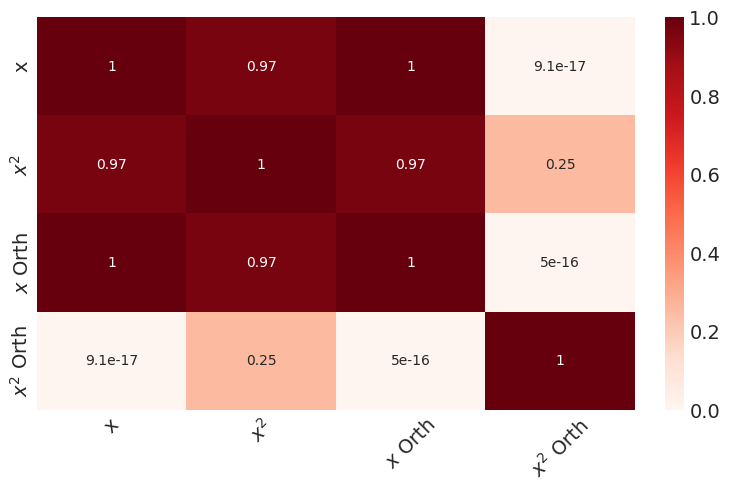

In [17]:
# Generate data
x = np.linspace(0, 10, 100)
x2 = x**2

# Orthogonalize
transformer = OrthogonalPolynomialTransformer(degree=2)
x_orthogonalized = transformer.fit_transform(x)
x_orth = x_orthogonalized[:, 0]
x2_orth = x_orthogonalized[:, 1]

# Make a correlation matrix
data = np.vstack([x, x2, x_orth, x2_orth]).T
df = pd.DataFrame(data, columns=['x', '$x^2$', '$x$ Orth', '$x^2$ Orth'])
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.xticks(rotation=45)
plt.show()


We now see that the orthogonalized version of $x$ and $x^2$ are no longer correlated to each other. Next, we construct a response variable and plot against it.

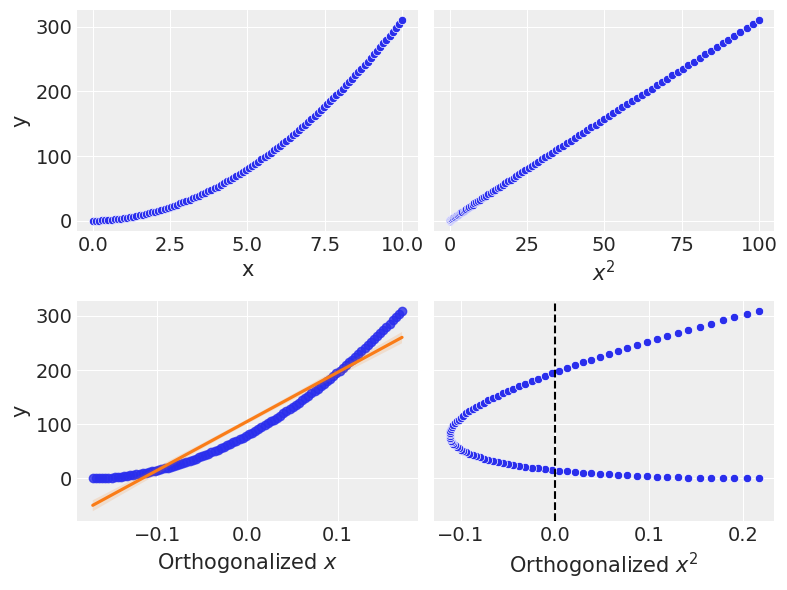

In [18]:
y = 3 * x2  + x

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey='row')

# Plot configurations - variable, label, linear fit tuple
plots = [
    (x, 'x', False),
    (x2, '$x^2$', False),
    (x_orth, 'Orthogonalized $x$', True), 
    (x2_orth, 'Orthogonalized $x^2$', False)
]

for ax, plot_data in zip(axs.flat, plots):
    x_val, xlabel = plot_data[:2]
    if len(plot_data) == 3 and plot_data[2]:  # Check if regression line is needed
        sns.regplot(x=x_val, y=y, ax=ax, line_kws={"color": "C1"})
    else:
        sns.scatterplot(x=x_val, y=y, ax=ax)
    ax.set(xlabel=xlabel, ylabel='y')

    # Check if this is the $x^2$ Orth vs y plot to add a vertical line at 0
    if plot_data[1] == 'Orthogonalized $x^2$':
        ax.axvline(0, color='k', linestyle='--')  # Add vertical line at x=0

plt.tight_layout()
plt.show()


The top half shows the response variable against $x$ and $x^2$, this should look familiar.

The bottom half shows the new orthogonalized polynomial terms. First, you'll notice the domain is centered at 0 and more compressed than the original scale, which is done within the orthogonalization process. Otherwise, the $x$ term is the same. Remember in the construction, the first order is untouched, then subsequent terms are built orthogonal to the first degree polynomial. 

I've shown a linear fit on top of the first order term. What you'll notice is that the orthogonalized $x^2$ correspond to the residuals of this line. At the lowest values of $y$, the fit is poor, and this is where the orthogonalized $x^2$ is highest. As the first order term crosses the linear fit, you see the orthogonalized $x^2$ cross zero, then go to negative values as it dips under the linear fit. It crosses 0 one more time and then is once again poor at the highest values shown. Since the $x^2$ is proportional to the residuals of the first order term, if we plot the orthogonalized $x^2$ term against the residuals, we should see a linear trend.

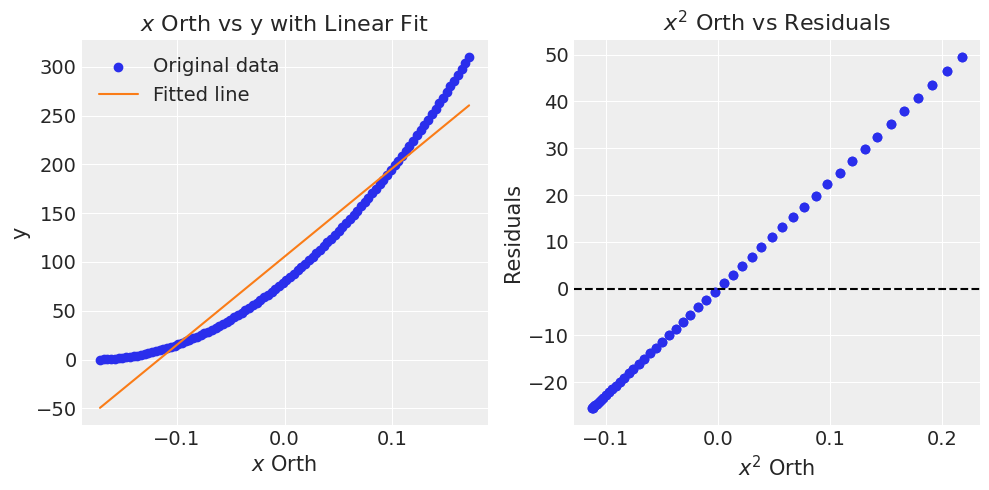

In [19]:
# Perform linear fit on x_orth vs y
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_orth, y)

# Calculate the residuals
y_pred = intercept + slope * x_orth
residuals = y - y_pred

# Plot x_orth vs y with linear fit
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_orth, y, label='Original data')
plt.plot(x_orth, y_pred, color='C1', label='Fitted line')
plt.xlabel('$x$ Orth')
plt.ylabel('y')
plt.title('$x$ Orth vs y with Linear Fit')
plt.legend()

# Plot x2_orth vs residuals
plt.subplot(1, 2, 2)
plt.scatter(x2_orth, residuals)
plt.xlabel('$x^2$ Orth')
plt.ylabel('Residuals')
plt.title('$x^2$ Orth vs Residuals')
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


And, in fact, the linear trend bears out when plotting the orthogonal $x^2$ vs the residuals.

We can take this a degree higher and look at a cubic term.

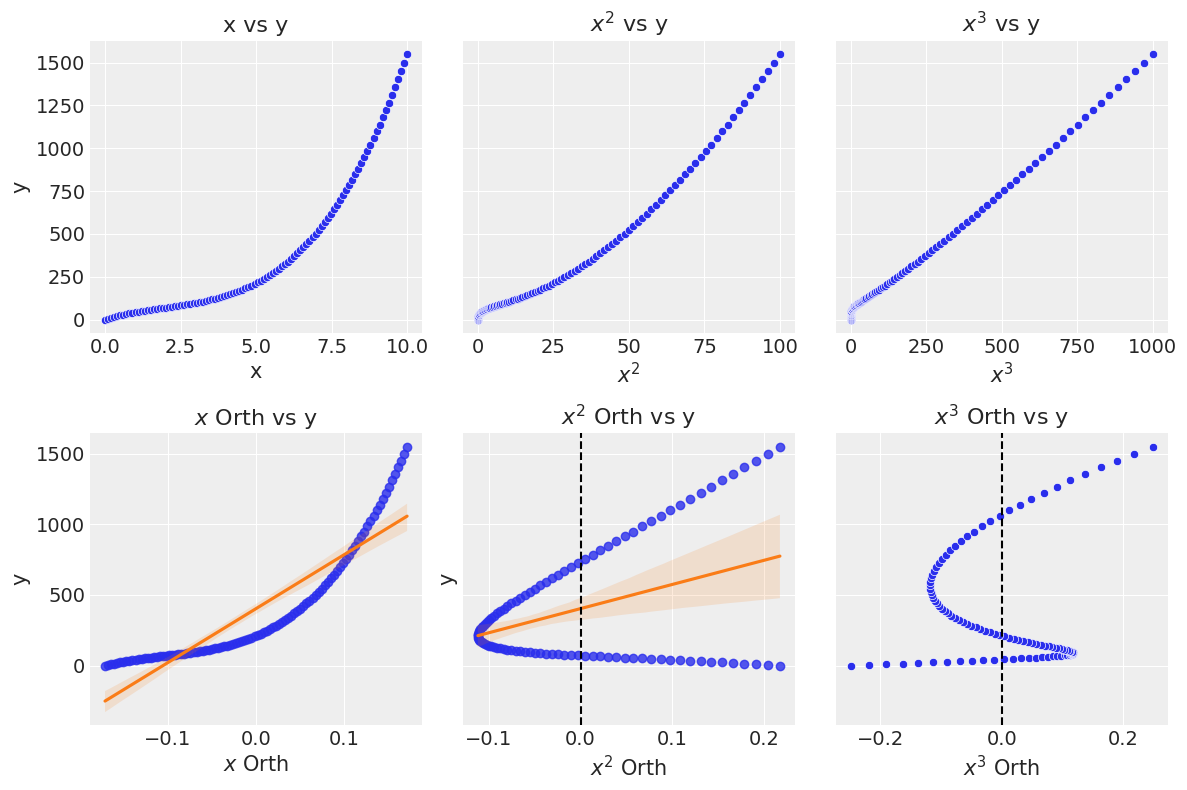

In [20]:
x3 = x**3
x2 = x**2
# Creating a cubic function with an up and down pattern
y_cubic = 2.5* x3 - 15*x2 + 55 * x 

transformer = OrthogonalPolynomialTransformer(degree=3)
x_orthogonalized = transformer.fit_transform(x)
x_orth = x_orthogonalized[:, 0]
x2_orth = x_orthogonalized[:, 1]
x3_orth = x_orthogonalized[:, 2]

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey='row')

# Plot configurations
plots = [
    (x, 'x', 'x vs y', False),
    (x2, '$x^2$', '$x^2$ vs y', False),
    (x3, '$x^3$', '$x^3$ vs y', False),
    (x_orth, '$x$ Orth', '$x$ Orth vs y', True),  # Indicate to add regression line for this plot
    (x2_orth, '$x^2$ Orth', '$x^2$ Orth vs y', True),  # Indicate to add regression line for this plot too
    (x3_orth, '$x^3$ Orth', '$x^3$ Orth vs y',False)
]

for ax, plot_data in zip(axs.flat, plots):
    x_val, xlabel, title = plot_data[:3]
    if len(plot_data) == 4 and plot_data[3]:  # Check if regression line is needed
        sns.regplot(x=x_val, y=y_cubic, ax=ax, line_kws={"color": "C1"})
    else:
        sns.scatterplot(x=x_val, y=y_cubic, ax=ax)
    ax.set(xlabel=xlabel, ylabel='y', title=title)

    # Check if this is the $x^2$ Orth vs y plot to add a vertical line at 0
    if title == '$x^2$ Orth vs y':
        ax.axvline(0, color='k', linestyle='--')  # Add vertical line at x=0
    # Check if this is the $x^3$ Orth vs y plot to add a vertical line at 0
    if title == '$x^3$ Orth vs y':
        ax.axvline(0, color='k', linestyle='--')  # Add vertical line at x=0

plt.tight_layout()
plt.show()


At a cubic level, it's a bit more difficult to see the trends, however, the procedure is still the same. We can model each subsequent term against the residuals of the prior, and we can see that since this data was constructed from a cubic function, the $x^3$ plot against the residuals of the $x^2$ term is linear.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


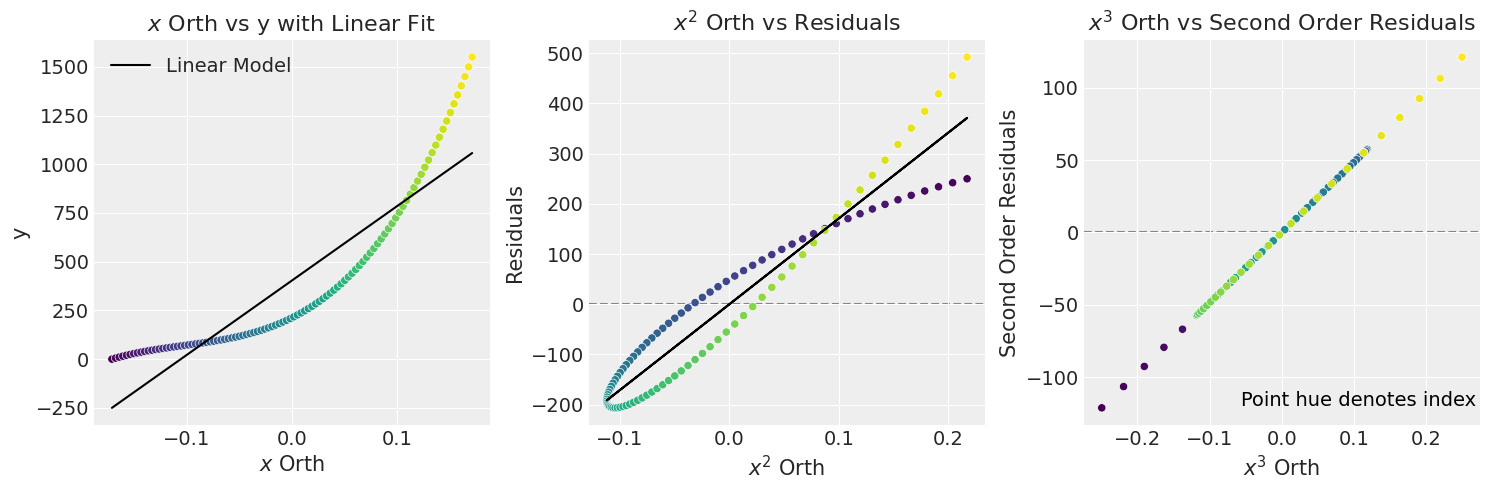

In [21]:
# Perform linear fit on x_orth vs y
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_orth, y_cubic)

# Calculate the residuals
y_pred = intercept + slope * x_orth
residuals = y_cubic - y_pred

# Perform linear fit on residuals vs x2_orth
slope_res, intercept_res, r_value_res, p_value_res, std_err_res = scipy.stats.linregress(x2_orth, residuals)

# Calculate the second order residuals
residuals_pred = intercept_res + slope_res * x2_orth
second_order_residuals = residuals - residuals_pred

# Plot x_orth vs y with linear fit
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=x_orth, y=y_cubic, hue=np.arange(len(x_orth)), palette="viridis", legend=False)
plt.plot(x_orth, y_pred, color='black', label='Linear Model')
plt.xlabel('$x$ Orth')
plt.ylabel('y')
plt.title('$x$ Orth vs y with Linear Fit')
plt.legend()

# Plot x2_orth vs residuals
plt.subplot(1, 3, 2)
sns.scatterplot(x=x2_orth, y=residuals, hue=np.arange(len(x2_orth)), palette="viridis", legend=False)
plt.plot(x2_orth, residuals_pred, color='black')
plt.xlabel('$x^2$ Orth')
plt.ylabel('Residuals')
plt.title('$x^2$ Orth vs Residuals')
plt.axhline(0, color='grey', linestyle='--', zorder=-1)
plt.legend()

# Plot x3_orth vs second order residuals
plt.subplot(1, 3, 3)
sns.scatterplot(x=x3_orth, y=second_order_residuals, hue=np.arange(len(x3_orth)), palette="viridis", legend=False)
plt.xlabel('$x^3$ Orth')
plt.ylabel('Second Order Residuals')
plt.title('$x^3$ Orth vs Second Order Residuals')
plt.axhline(0, color='grey', linestyle='--', zorder=-1)
plt.annotate('Point hue denotes index', 
             xy=(0.99, 0.05), ha='right', xycoords='axes fraction', fontsize=14, color='black')

plt.tight_layout()
plt.show()


The main takeaway of this deep dive is the following: **The `poly` keyword when used in a formula creates orthogonal polynomials. This is well-suited for fitting statistical models, since it eliminates the risk of multicollinearity between terms.** 

This wasn't used in the other notebook since we were trying to recover parameters associated with each term. However, if you're building a statistical model, especially one in which prediction is the focus, they may be the appropriate approach.

As one final note, the formulae version of `poly` does include a `raw` argument, which allows you to get the non-orthogonalized versions of each polynomial term. You can call that in Bambi like `bmb.Model("y ~ poly(x, 4, raw=True)", df)`.

## Orthogonal Polynomials in Practice

In order to see the `poly` keyword in action, we'll take a look at the cars dataset. This dataset, preloaded into Seaborn, includes information on cars manufactured between 1970-1982. First we'll load it in and take a look at the included variables.

In [22]:
df_mpg = sns.load_dataset("mpg")
df_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In this example, we'll take a look at how a car's fuel efficiency (`mpg`) relates to it's `horsepower` (hp).

To start, we'll just plot the joint distribution, as well as the distribution of the response variable as well.

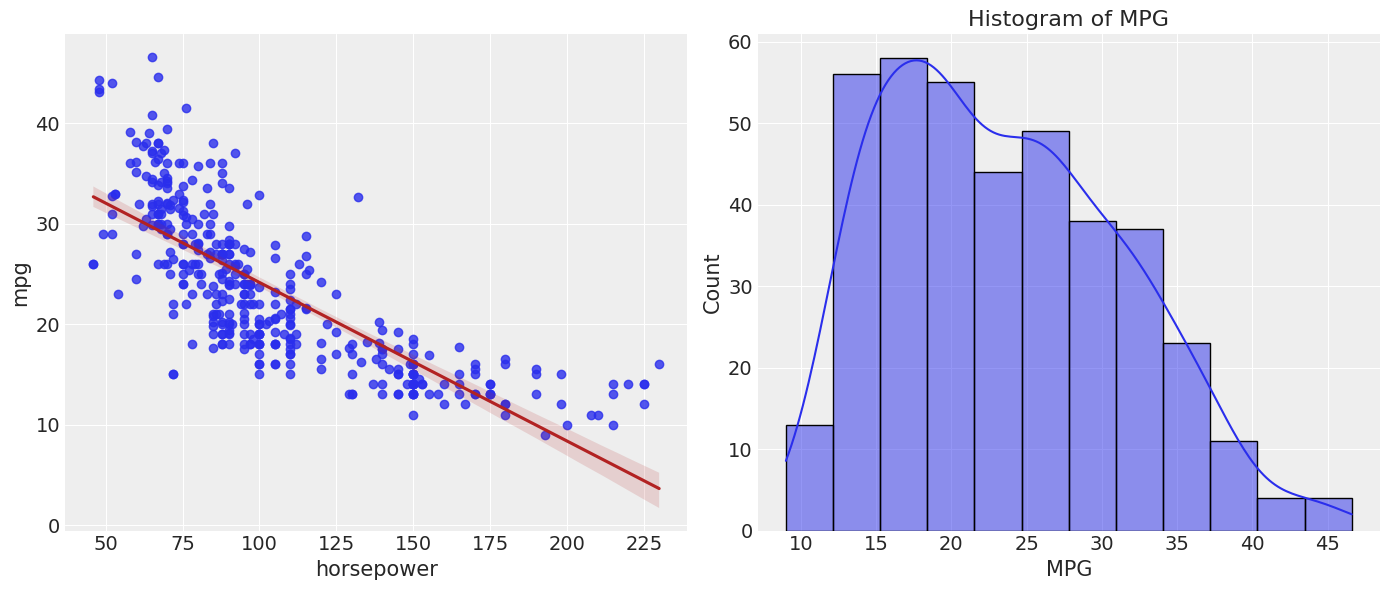

In [23]:
df_mpg = df_mpg.dropna(subset=["horsepower", "mpg"])


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.regplot(data=df_mpg, x="horsepower", y="mpg", line_kws={"color": "firebrick"})

plt.subplot(1, 2, 2)
sns.histplot(df_mpg["mpg"], edgecolor="black", kde=True)
plt.xlabel('MPG')
plt.ylabel('Count')
plt.title('Histogram of MPG')

plt.tight_layout()
plt.show()


Immediately, we see that the linear fit doesn't seem to model this data perfectly, it exhibits some nonlinearity. We'll use a polynomial regression in order to see if we can improve that fit and capture the curvature. We will first fit a linear model as a benchmark.

In [24]:
mpg_hp_linear_mod = bmb.Model("mpg ~ horsepower", df_mpg)
mpg_hp_linear_fit = mpg_hp_linear_mod.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)
mpg_hp_linear_mod.predict(mpg_hp_linear_fit, kind="response")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, horsepower]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Default computed for conditional variable: horsepower
Default computed for conditional variable: horsepower


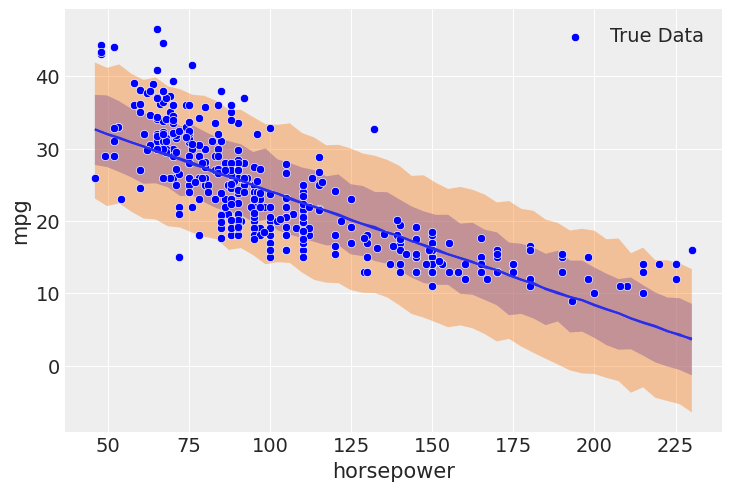

In [25]:
fig = plt.figure()
for p in [.68, .95]:
    bmb.interpret.plot_predictions(
        mpg_hp_linear_mod,
        mpg_hp_linear_fit,
        "horsepower",
        pps=True,
        legend=True,
        prob=p,
        ax=plt.gca()
    )
sns.scatterplot(data=df_mpg, x="horsepower", y="mpg", color='blue', label='True Data');

Looking at this plot with the 68% and 95% CIs shown, the fit looks _okay_. Most notably, at about 160 hp, then the data diverge from the fit pretty drastically. The fit at low hp values isn't particularly good either, there's quite a bit that falls outside of our 95% CI. This can be accented pretty heavily by looking at the the residuals from the mean of the model.

Text(0.5, 1.0, 'Residuals for linear model')

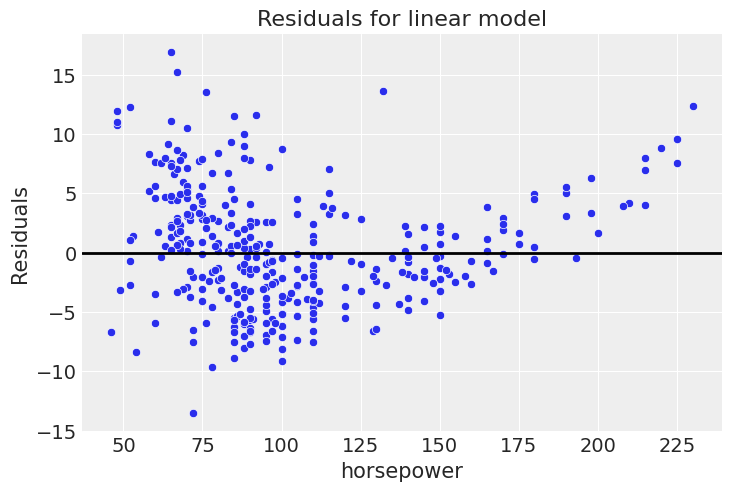

In [26]:
predicted_mpg = mpg_hp_linear_fit.posterior["mu"].mean(("chain", "draw"))
residuals = df_mpg["mpg"] - predicted_mpg
sns.scatterplot(data=df_mpg, x="horsepower", y=residuals)
plt.axhline(0, color='black', lw=2)
plt.ylabel("Residuals")
plt.title('Residuals for linear model')


This is definitely not flat like we would ideally like it.

Next we fit a polynomial regression, including a square term.

In [27]:
mpg_hp_sq_mod = bmb.Model("mpg ~ poly(horsepower, 2)", df_mpg)
mpg_hp_sq_fit = mpg_hp_sq_mod.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED)
mpg_hp_sq_mod.predict(mpg_hp_sq_fit, kind="response")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(horsepower, 2)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Default computed for conditional variable: horsepower
Default computed for conditional variable: horsepower


Text(0.5, 1.0, 'Quadratic Fit')

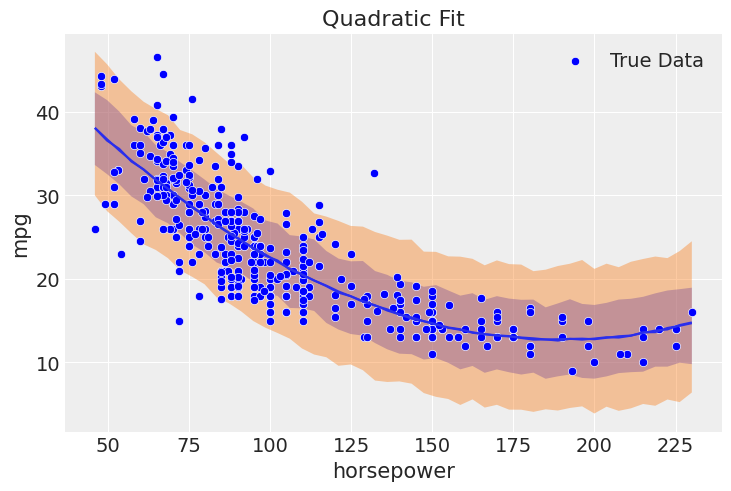

In [28]:
fig = plt.figure()
for p in [.68, .95]:
    bmb.interpret.plot_predictions(
        mpg_hp_sq_mod,
        mpg_hp_sq_fit,
        "horsepower",
        pps=True,
        legend=True,
        prob=p,
        ax=plt.gca()
    )
sns.scatterplot(data=df_mpg, x="horsepower", y="mpg", color='blue', label='True Data')
plt.title("Quadratic Fit")

Visually, this seems to look better. Particularly at high values, the model follows the pattern in the data much, much better, since we allow for curvature by including the polynomial term. Generating the same residual plot gives the following,

Text(0.5, 1.0, 'Residuals for quadratic model')

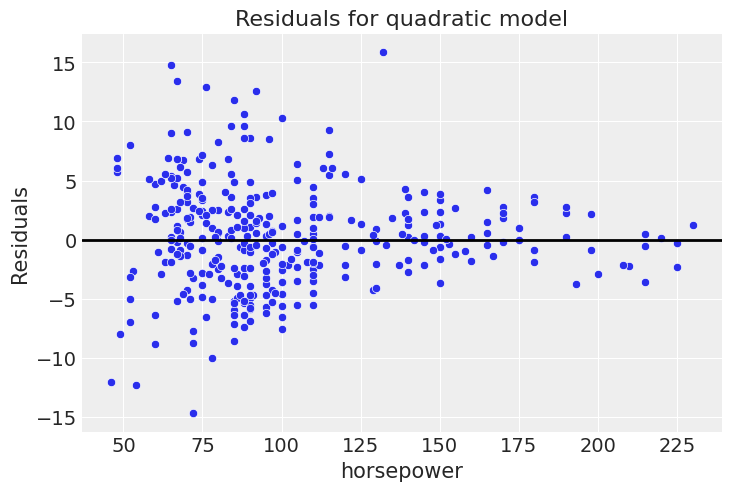

In [29]:
predicted_mpg = mpg_hp_sq_fit.posterior["mu"].mean(("chain", "draw"))
residuals = df_mpg["mpg"] - predicted_mpg
sns.scatterplot(data=df_mpg, x="horsepower", y=residuals)
plt.axhline(0, color='black', lw=2)
plt.ylabel("Residuals")
plt.title('Residuals for quadratic model')


This is far closer to flat than before.

For a true comparison, we can look at the elpd difference between the models.

In [30]:
az.compare({"Linear": mpg_hp_linear_fit, "Quadratic": mpg_hp_sq_fit})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Quadratic,0,-1137.457520,4.391553,0.000000,0.915406,18.118483,0.00000,False,log
Linear,1,-1182.021676,3.548755,44.564155,0.084594,15.109327,10.36876,False,log


The quadradic model performs better by LOO-CV.

### Cautionary Tales

Last, we're going to investigate a couple of pitfalls with polynomial regression. 

#### Fitting too many polynomial degrees

Typically, when fitting a statistical model, you want to come to your data with a hypothesis and motivate your polynomial degree based on domain knowledge and expertise with the data. Instead of being principled, we're going to throw caution to the wind and iteratively fit models from degree 1-10 and then see which performs best.

In [32]:
poly_fits, poly_models = {}, {}
for degree in range(1, 10):
    model = bmb.Model(f"mpg ~ poly(horsepower, {degree})", df_mpg)
    fit = model.fit(idata_kwargs={"log_likelihood": True}, random_seed=SEED, progressbar=False)
    poly_models[f"Poly{degree}"] = model
    poly_fits[f"Poly{degree}"] = fit

cmp = az.compare(poly_fits)
cmp

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(horsepower, 1)]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(horsepower, 2)]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(horsepower, 3)]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(horsepower, 4)]
Sampling 4 chains for 1_000 tun

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Poly7,0,-1133.056651,9.286158,0.000000,6.605585e-01,18.850219,0.000000,False,log
Poly6,1,-1134.077639,8.816832,1.020989,4.232600e-13,18.638394,1.793307,False,log
Poly8,2,-1134.642557,10.942848,1.585906,4.274684e-13,18.820855,0.664368,True,log
Poly5,3,-1134.839670,7.652049,1.783020,4.280794e-13,18.505057,3.502449,False,log
Poly9,4,-1135.162445,11.876625,2.105794,4.271587e-13,18.921941,1.593423,True,log
Poly2,5,-1137.457507,4.391540,4.400857,4.134037e-13,18.118477,6.449275,False,log
Poly3,6,-1138.255418,5.693683,5.198768,2.744510e-01,18.401059,6.961385,False,log
Poly4,7,-1138.824420,7.106027,5.767770,4.337785e-13,18.322672,6.128835,False,log
Poly1,8,-1181.947800,3.478546,48.891149,6.499044e-02,15.115759,10.986985,False,log


Wow! A 7th-degree polynomial seems to do better than the quadratic one we fit before. But we must also notice that most ELPD values are very similar. Let's do a plot, so we can more easily grasp how different models are according to the ELPD. We are going to use  `az.plot_compare`, and we are going to add a blue band to indicate models that have an ELPD difference of less than 4 with respect to the first-ranked model. Essentially models that are that close can not be distinguished when using ELPD.

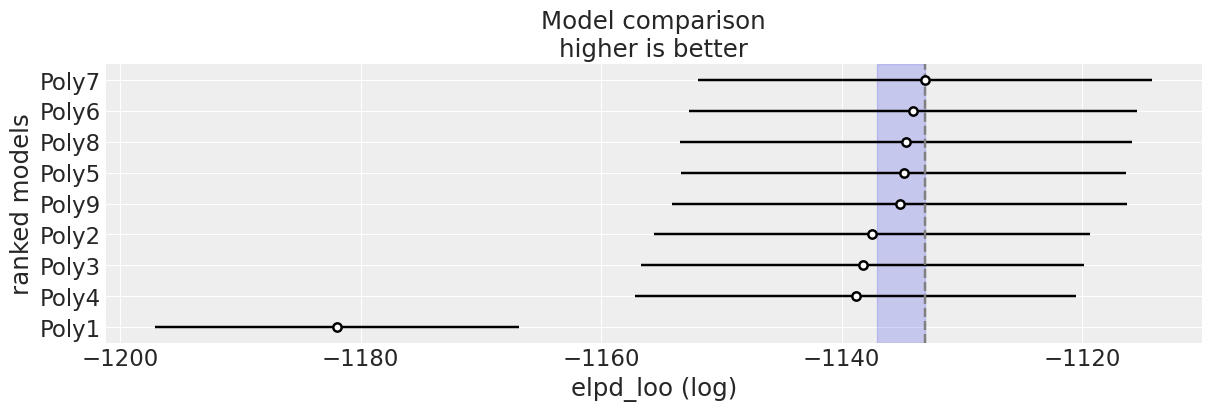

In [33]:
ax = az.plot_compare(cmp, figsize=(12, 4), plot_ic_diff=False, legend=False);
best_loo = cmp["elpd_loo"].iloc[0]
ax.axvspan(best_loo-4, best_loo, color="C0", alpha=0.2);

We can see that `Poly6`, `Poly8`, `Poly5` and `Poly9` are all very similar (within a difference of 4 units). Evenmore, all model except from `Poly1` have overlaping standard errors. 

Overall, this is telling us that there is no clear gain in predictive performance once we move beyond a quadratic model. If we want to pick a single model, then we need another criteria to decide. If we have no reason to prefer a more complex model, choosing the simpler one (`Poly2` in this example) is a good heuristic.

Before deciding let's do a couple more plot. First, see what those residuals look like!

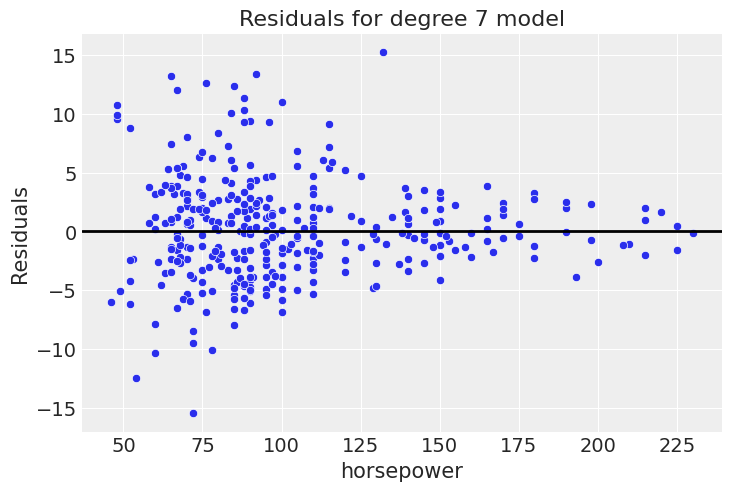

In [34]:
best_model = poly_models["Poly7"]
best_fit = poly_fits["Poly7"]
best_model.predict(best_fit, kind="response")

predicted_mpg = best_fit.posterior["mu"].mean(("chain", "draw"))
residuals = df_mpg["mpg"] - predicted_mpg
sns.scatterplot(data=df_mpg, x="horsepower", y=residuals)
plt.axhline(0, color='black', lw=2)
plt.ylabel("Residuals")
plt.title('Residuals for degree 7 model');

Hey, that looks pretty good, the residuals appear nice and flat. Before we go full steam ahead with this model, let's take a look at the posterior predictive distribution.

Default computed for conditional variable: horsepower
Default computed for conditional variable: horsepower


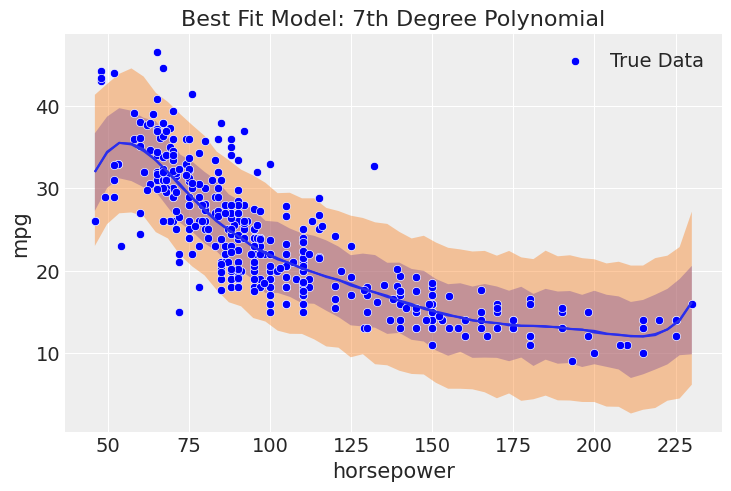

In [35]:
fig = plt.figure()
for p in [.68, .95]:
    bmb.interpret.plot_predictions(
        best_model,
        best_fit,
        "horsepower",
        pps=True,
        legend=True,
        prob=p,
        ax=plt.gca()
    )
sns.scatterplot(data=df_mpg, x="horsepower", y="mpg", color='blue', label='True Data')
plt.title("Best Fit Model: 7th Degree Polynomial");

Uh-oh. You can see that while this gave the best elpd, and had a nice residual plot, it's obviously overfit, as expected given that we already show that the difference with the quadratic model is small. Given our knowledge about how cars operate, we expect a decreasing trend of fuel efficiency at higher horsepower. The 7th degree polynomial absolutely is not consistent with that. First, looking at the low values, it increases before starting the decreasing trend. Second, it starts to go back up at the high end of the data, strongly latching onto a couple of points that are likely driven by noise.

This behavior evokes the classic quote,

> "With four parameters I can fit an elephant, and with five I can make him wiggle his trunk." - John von Neumann

The takeaway here is that **as you fit higher polynomial degrees, you increase the risk of overfitting**.

#### Extrapolation of polynomial models

With any model, we should be careful when extrapolating and ensure our assumptions hold, but this particularly applies when considering polynomial regression. Since we consider the higher order polynomials, terms can quickly blow up outside of our domain.

For example, with the quadratic fit, we see that the drop in mpg flattens out at higher horsepower. However, if you look closely at the posterior predictive of the quadratic model, you can start to see the fit rise again at the end. But, if we extend this beyond the bounds, due to the curvature of a second degree polynomial, we see a reversal of the negative effect on horsepower, where our quadratic model implies a higher horsepower leads to _better_ mpg.

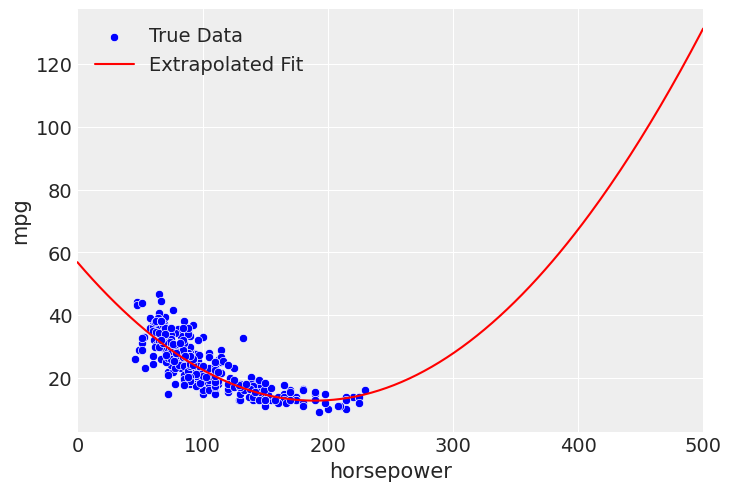

In [36]:
extrapolate_x_hp = np.linspace(0, 500, 250)  
mpg_hp_sq_mod.predict(mpg_hp_sq_fit, data=pd.DataFrame({"horsepower": extrapolate_x_hp}))

sns.scatterplot(data=df_mpg, x="horsepower", y="mpg", color='blue', label='True Data')
plt.plot(
    extrapolate_x_hp,
    mpg_hp_sq_fit.posterior["mu"].mean(("chain", "draw")),
    color="red",
    label="Extrapolated Fit",
)
plt.xlim(left=0, right=extrapolate_x_hp.max())

plt.legend(frameon=False)


This is strictly untrue based on what we know about cars and what we've seen in the data, so you would _not_ want to use the model outside of the intended domain. If that is the goal, you would want to find more appropriate specification. Something like an exponential or inverse fit may be appropriate, in order to make sure the fit approaches 0, while still forbidding predictions below 0.

Extrapolation issues are not unique to polynomial regression, for example we run into forbidden values with linear regression when extrapolating too.

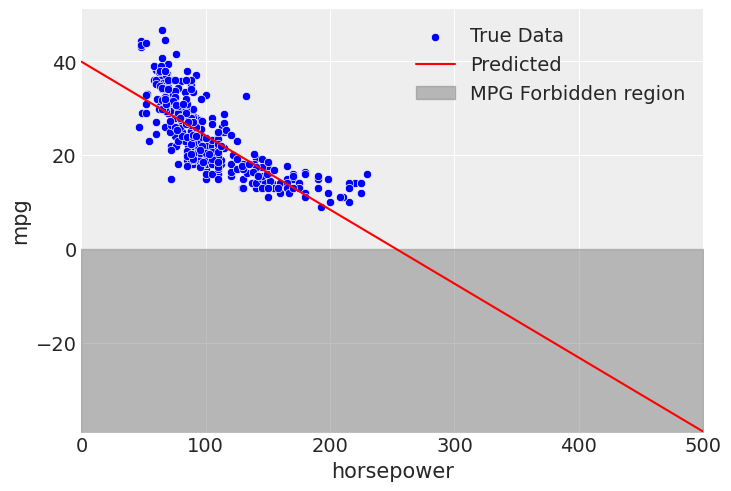

In [37]:
mpg_hp_linear_mod.predict(mpg_hp_linear_fit, data=pd.DataFrame({"horsepower": extrapolate_x_hp}))
sns.scatterplot(data=df_mpg, x="horsepower", y="mpg", color='blue', label='True Data')

plt.plot(
    extrapolate_x_hp,
    mpg_hp_linear_fit.posterior["mu"].mean(("chain", "draw")),
    color="red",
    label="Predicted"
)
plt.fill_between(extrapolate_x_hp, plt.ylim()[0], 0, color='grey', alpha=0.5, label="MPG Forbidden region")
plt.xlim(left=0, right=extrapolate_x_hp.max())
plt.ylim(bottom=mpg_hp_linear_fit.posterior["mu"].mean(("chain", "draw")).min())
plt.legend(frameon=False);

However, it is highlighted in this notebook because, due to the nature of polynomial regression, it can be very sensitive outside the fitting domain. Just for fun to wrap this notebook up, we will take a look at what the 7th order "best model" does outside of where we fit the model.

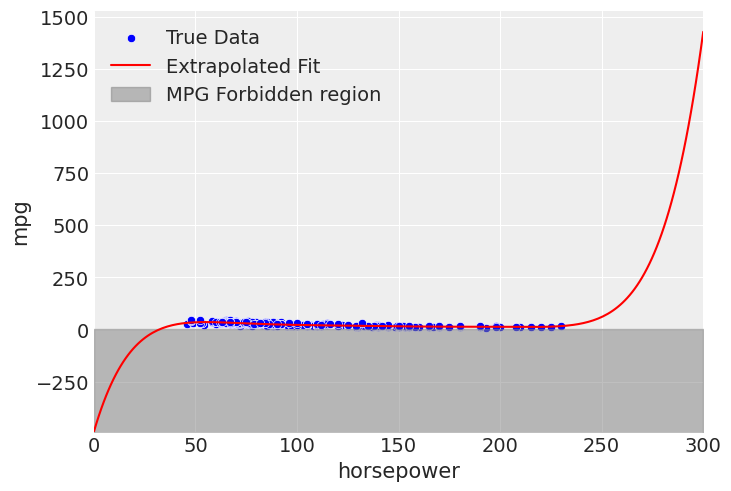

In [38]:
extrapolate_x_hp = np.linspace(0, 300, 250)  
best_model.predict(best_fit, data=pd.DataFrame({"horsepower": extrapolate_x_hp}))

sns.scatterplot(data=df_mpg, x="horsepower", y="mpg", color='blue', label='True Data')
plt.plot(
    extrapolate_x_hp,
    best_fit.posterior["mu"].mean(("chain", "draw")),
    color="red",
    label="Extrapolated Fit",
)
plt.fill_between(extrapolate_x_hp, plt.ylim()[0], 0, color='grey', alpha=0.5, label="MPG Forbidden region")

plt.xlim(left=0, right=extrapolate_x_hp.max())
plt.ylim(bottom=best_fit.posterior["mu"].mean(("chain", "draw")).min())
plt.legend(frameon=False);

Yikes.

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jul 11 2024

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.16.1

bambi     : 0.12.1.dev63+g18e3db6f.d20240711
scipy     : 1.11.4
pandas    : 2.1.2
numpy     : 1.24.4
seaborn   : 0.13.2
arviz     : 0.19.0.dev0
formulae  : 0.5.3
matplotlib: 3.8.4

Watermark: 2.4.3

